In [8]:
# from kaggle_secrets import UserSecretsClient
# user_secrets = UserSecretsClient()
# github_token = user_secrets.get_secret("github-token")
# wandb_key = user_secrets.get_secret("wandb-key")

# !git clone https://$github_token@github.com/dimka11/trash_containers_cls.git

In [9]:
!pip install git+https://github.com/rwightman/pytorch-image-models
!pip install -q -U albumentations

  Cloning https://github.com/rwightman/pytorch-image-models to /tmp/pip-req-build-ai6fyn1w
  Running command git clone --filter=blob:none --quiet https://github.com/rwightman/pytorch-image-models /tmp/pip-req-build-ai6fyn1w
  Resolved https://github.com/rwightman/pytorch-image-models to commit beef62e7abc725df1be55f3057ceeea038ff9acd
  Preparing metadata (setup.py) ... done
  Created wheel for timm: filename=timm-0.6.2.dev0-py3-none-any.whl size=499021 sha256=d3b44f8aa91ae6bbefb6725005d226a1d60fdfb121450d72a3cb4e412a19743f
  Stored in directory: /tmp/pip-ephem-wheel-cache-yyvfvrau/wheels/69/3d/b0/be55cbadabd87a0e1875d63c7492d199097a39cc2433637650
Successfully built timm


In [10]:
import numpy as np
import pandas as pd
import os
import glob

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Flatten

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import models
import PIL

import timm
from pprint import pprint

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

Random

In [11]:
# import torch
# torch.manual_seed(0)

# import random
# random.seed(0)

# import numpy as np
# np.random.seed(0)

# def seed_worker(worker_id):
#     worker_seed = torch.initial_seed() % 2**32
#     numpy.random.seed(worker_seed)
#     random.seed(worker_seed)

# g = torch.Generator()
# g.manual_seed(0)

# DataLoader(
#     train_dataset,
#     batch_size=batch_size,
#     num_workers=num_workers,
#     worker_init_fn=seed_worker,
#     generator=g,
# )

In [12]:
train_csv = pd.read_csv('../input/trash-containers/train_dataset_train/train.csv')

# EDA

<AxesSubplot:xlabel='class', ylabel='count'>

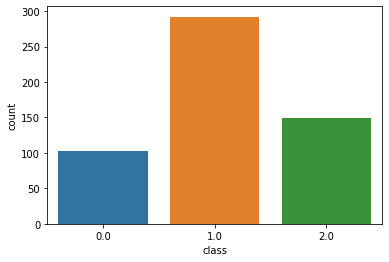

In [13]:
sns.countplot(x = "class" , data  = train_csv)

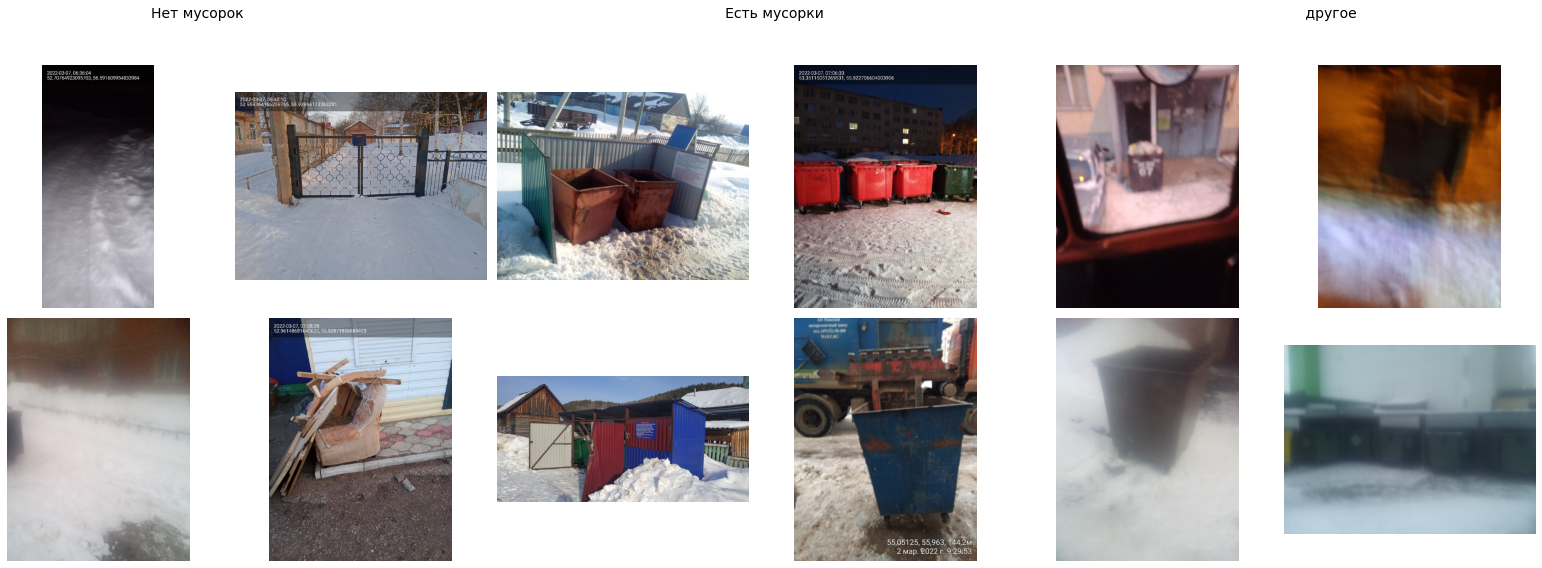

In [14]:
fig, axs = plt.subplots(2, 6, figsize=(22,8))
fig.suptitle(f'Нет мусорок {" "*105} Есть мусорки {" "*105} другое', fontsize=14)

train_path = '../input/trash-containers/train_dataset_train/train'

for i, name in zip(range(4), train_csv[ train_csv['class'] == 0 ].sample(4, random_state=42)['ID_img']):
    axs[i // 2, (i % 2)].imshow(plt.imread(f"{train_path}/{name}"))
    axs[i // 2, (i % 2)].axis('off')

for i, name in zip(range(4), train_csv[ train_csv['class'] == 1 ].sample(4, random_state=42)['ID_img']):
    axs[i // 2, (i % 2)+2].imshow(plt.imread(f"{train_path}/{name}"))
    axs[i // 2, (i % 2)+2].axis('off')
    
for i, name in zip(range(4), train_csv[ train_csv['class'] == 2 ].sample(4, random_state=42)['ID_img']):
    axs[i // 2, (i % 2)+4].imshow(plt.imread(f"{train_path}/{name}"))
    axs[i // 2, (i % 2)+4].axis('off')

fig.tight_layout()
fig.subplots_adjust(top=0.88)

In [15]:
# prepare test/val csv file

val_csv = pd.read_csv('../input/trash-containers/annotations_test_visual.csv', index_col=0)
val_csv = val_csv.drop(columns=['id', 'annotator', 'created_at', 'updated_at', 'lead_time', 'annotation_id'])
val_csv = val_csv.rename(columns={'choice':'class'})
val_csv.index = val_csv.index.str.split('/').str[-1].str.split('-').str[-1]
val_csv.to_csv('./test_val.csv')

Change class [0, 1, 2] to [0, 2] to [0, 1]

In [16]:
val_csv['class'] = val_csv['class'].replace({1:0})
val_csv['class'] = val_csv['class'].replace({2:1})
val_csv['class'] = val_csv['class'].astype(int)
val_csv.to_csv('./test_val.csv')

train_csv['class'] = train_csv['class'].replace({1:0})
train_csv['class'] = train_csv['class'].replace({2:1})
train_csv['class'] = train_csv['class'].astype(int)
train_csv.to_csv('./train_csv.csv', index=False)

Class weights

In [17]:
class_weights = compute_class_weight('balanced', classes=[0,1], y=train_csv['class'])

# class_sample_count = np.unique(train_csv['class'].astype(int), return_counts=True)[1]
# weight = 1. / class_sample_count
# samples_weight = weight[train_csv['class'].astype(int)]
# samples_weight = torch.from_numpy(samples_weight)

In [18]:
class Config:
    IMG_SIZE_H = 224
    IMG_SIZE_W = 224
    BATCH_SIZE = 16
    EPOCHS = 10
    FT_EPOCHS = 31
    VAL_IN_EPOCHS = 3
    DEVICE = torch.device('cuda')
    MODEL_LOAD_PATH = '/content/best_model.pt'
    train_images = '../input/trash-containers/train_dataset_train/train'
    test_images = '../input/trash-containers/test_dataset_test'
    test_val_csv_path = './test_val.csv'
    train_csv_path = './train_csv.csv'
    train = True
    val = True
    inference = True
    load_weights = True
    weights_path = '../input/trash-containers-cls-weights/best_model_0_0.87.pt'
    new_current_weights_path = None

class ModelConfig:
    model_name = ''
    base_lr = 3e-3
    ft_lr = 3e-5
    opt = 'adamw'
    loss = ''

# Augmentations

In [19]:
transform_train = transforms.Compose([
        #  transforms.CenterCrop(2048),
        #  transforms.RandomResizedCrop(2048),
         transforms.Resize((Config.IMG_SIZE_H, Config.IMG_SIZE_W)),
         transforms.RandomHorizontalFlip(),
#          transforms.RandomVerticalFlip(),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225]),
])

transform_test = transforms.Compose([
        #  transforms.CenterCrop(2048),
         transforms.Resize((Config.IMG_SIZE_H, Config.IMG_SIZE_W)),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225]),
])

# DataSet

In [20]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, csv_path, images_folder, transform = None):
        self.df = pd.read_csv(csv_path, index_col=0)
        self.images_folder = images_folder
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        filename = self.df.iloc[index].name
        label = int(self.df.iloc[index, 0])
        image = PIL.Image.open(os.path.join(self.images_folder, filename))
        
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [21]:
class CustomInferenceDataset(torch.utils.data.Dataset):
    def __init__(self, images_folder, test_transform = None):
        self.images_folder = images_folder
        self.transform = test_transform
        self.list_files = sorted(glob.glob(f'{images_folder}/*.jp*'))

    def __len__(self):
        return len(self.list_files)
                                           
    def __getitem__(self, index):
        file_name = self.list_files[index]
        image = PIL.Image.open(file_name)
        if self.transform is not None:
            image = self.transform(image)
        return image, file_name.split('/')[-1]

In [22]:
train_ds = CustomDataset(Config.train_csv_path, Config.train_images, transform=transform_train)
val_ds = CustomDataset(Config.test_val_csv_path, Config.test_images, transform=transform_test)
test_ds = CustomInferenceDataset(Config.test_images, test_transform=transform_test)

In [23]:
# train_ds[0]
# len(train_ds)

Split to train/val (unused)

In [24]:
def subset_ind(dataset, ratio: float):
    return np.random.choice(len(dataset), size=int(ratio*len(dataset)), replace=False)

train_val_split = False

if train_val_split:
    val_size = 0.2
    val_inds = subset_ind(train_ds, val_size)

    train_dataset = Subset(train_ds, [i for i in range(len(train_ds)) if i not in val_inds])
    val_dataset = Subset(train_ds, val_inds)
    train_ds = train_dataset

    print(f'training size: {len(train_dataset)}\nvalidation size: {len(val_dataset)}')

In [25]:
train_loader = DataLoader(train_ds, batch_size=Config.BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=Config.BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=Config.BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=2)

# Model

In [26]:
model_names = timm.list_models(pretrained=True)
# pprint(model_names)

In [27]:
models_names_s = ['swin_large_patch4_window12_384_in22k', 'swin_large_patch4_window7_224', 'swin_base_patch4_window12_384_in22k', 'vit_small_patch16_384', 'swinv2_base_window8_256']

In [28]:
model = timm.create_model(models_names_s[1], in_chans = 3, pretrained = True, num_classes=0, global_pool='avg') # global_pool='catavgmax' # features_only=True
print(model.default_cfg)

/opt/conda/lib/python3.7/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:2227.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Downloading: "https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_large_patch4_window7_224_22kto1k.pth" to /root/.cache/torch/hub/checkpoints/swin_large_patch4_window7_224_22kto1k.pth


{'url': 'https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_large_patch4_window7_224_22kto1k.pth', 'num_classes': 1000, 'input_size': (3, 224, 224), 'pool_size': None, 'crop_pct': 0.9, 'interpolation': 'bicubic', 'fixed_input_size': True, 'mean': (0.485, 0.456, 0.406), 'std': (0.229, 0.224, 0.225), 'first_conv': 'patch_embed.proj', 'classifier': 'head', 'architecture': 'swin_large_patch4_window7_224'}


In [29]:
dummy_image = torch.randn(1, 3, Config.IMG_SIZE_H, Config.IMG_SIZE_W)
model.forward_features(dummy_image).shape
model.forward(dummy_image).shape

torch.Size([1, 1536])

In [30]:
class SWIN(nn.Module):
    def __init__(self):
        super().__init__()
        self.swin = timm.create_model(models_names_s[1], in_chans = 3, pretrained = True, num_classes=0)
        for param in self.swin.parameters():
            param.requires_grad = False

        self.flatten = Flatten()
        self.fc = nn.Linear(1536, 1)
    
    def forward(self, x):
        x = self.swin(x)
        # x = self.flatten(x)
        x = self.fc(x)
        return x

    def set_parameter_requires_grad(self, freeze: bool):
        for param in self.swin.parameters():
            param.requires_grad = not freeze
        if not freeze:
            for name ,child in (self.swin.named_children()):
                if name.find('BatchNorm') != -1:
                    for param in child.parameters():
                        param.requires_grad = False

# Train

In [31]:
def save_model(epoch, net, optimizer, loss, metrics):
    #                     torch.save(net.state_dict(), f'./best_model_{epoch}_{str(np.round(metrics, 3))}.pt')
    torch.save({
        'epoch': epoch, 'model_state_dict': net.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss, }, f'./best_model_{epoch}_{str(np.round(metrics, 3))}.pt')
    Config.new_current_weights_path = f'./best_model_{epoch}_{str(np.round(metrics, 3))}.pt'

In [36]:
def train_batch_step(batch, device, optimizer, loss_fn, epoch_loss, train_size, train_pred):
    X_batch, y_batch = batch

    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)

    optimizer.zero_grad()
    y_pred = net(X_batch)

    loss = loss_fn(y_pred.view(-1), y_batch.float())
    
    loss.backward()
    optimizer.step()

    y_pred = torch.sigmoid(y_pred)
    y_pred = y_pred.view(-1)
    y_pred = torch.where(y_pred > 0.5, 1, 0)
    y_batch = y_batch.view(-1)

    epoch_loss += y_pred.shape[0] * loss.item()

    train_size += y_pred.size(0)
    train_pred += torch.sum(y_pred == y_batch)
    
    return epoch_loss, train_size, train_pred, loss
    
def val_batch_step(batch, device, net, loss_fn, epoch_val_loss, accuracy_all, targets_count):
    images, y_true = batch
    images = images.to(device)
    y_true = y_true.to(device)
    y_pred = net(images)
    loss = loss_fn(y_pred.view(-1), y_true.float())

    y_pred = torch.sigmoid(y_pred)
    y_pred = torch.where(y_pred > 0.5, 1, 0)
    y_pred = y_pred.view(-1)
    y_true = y_true.view(-1)
    y_pred = y_pred.detach().cpu().numpy()
    y_true = y_true.detach().cpu().numpy() 

    epoch_val_loss += y_pred.shape[0] * loss.item()

    accuracy_all += np.sum(y_pred == y_true)
    targets_count += y_pred.shape[0]
    
    return epoch_val_loss, accuracy_all, targets_count

In [40]:
class SaveMetrics: # unused now
    def __init__(self):
        
        self.metrics = {}
        self.metrics['best_metrics'] = 0
        self.metrics['train_acc_log'] = []
        self.metrics['train_size'] = 0
        self.metrics['train_pred'] = 0.0
        self.metrics['epoch_loss'] = 0.0
        self.metrics['epoch_val_loss'] =0.0
        self.metrics['accuracy_all'] = 0
        self.metrics['targets_count'] = 0
        
    def reset_on_start():
        self.metrics['best_metrics'] = 0
        self.metrics['train_acc_log'] = []
    def reset_on_epoch():
        self.metrics['train_size'] = 0
        self.metrics['train_pred'] = 0.
        self.metrics['epoch_loss'] = 0.0
        self.metrics['epoch_val_loss'] = 0.0
        
        self.metrics['accuracy_all'] = 0
        self.metrics['targets_count'] = 0
        
    def update(metrics):
        for key, value in metrics.items():
            self.metrics[key] = value
    def get():
        return self.metrics

save_metrics = SaveMetrics()

In [37]:
def train(net, loss_fn, optimizer, train_loader,val_loader, n_epoch=10):
    best_metrics = 0
    device = Config.DEVICE
    train_acc_log = []
    
    net.train()

    for epoch in range(n_epoch):
        print(f'Epoch {epoch + 1}')
        
        train_size = 0
        train_pred = 0.
        epoch_loss = 0.0
        epoch_val_loss = 0.0
        
        train_dataiter = iter(train_loader)
        for i, batch in enumerate(tqdm(train_dataiter)):
            epoch_loss, train_size, train_pred, loss = train_batch_step(batch, device, optimizer, loss_fn, epoch_loss, train_size, train_pred)

        train_acc_log.append(train_pred / train_size)
        print('train loss: ', epoch_loss / len(train_dataiter))
        print('train acc: ', (train_pred / train_size).detach().cpu().numpy())

        if (epoch % Config.VAL_IN_EPOCHS) == 0:
            with torch.no_grad():
                net.eval()
                accuracy_all = 0.0
                targets_count = 0
                
                for batch in val_loader:
                    epoch_val_loss, accuracy_all, targets_count = val_batch_step(batch, device, net, loss_fn, epoch_val_loss, accuracy_all, targets_count)

                accuracy_all = accuracy_all / targets_count
                
                print('val loss: ', epoch_val_loss / len(val_loader))
                print(f'accuracy: {accuracy_all}')
                
                if accuracy_all > best_metrics:
                    print('New best model with test acc:', accuracy_all)
                    save_model(epoch, net, optimizer, loss, accuracy_all)
                    best_metrics = accuracy_all

    return net

In [38]:
torch.cuda.empty_cache()
import gc
gc.collect()

134

In [39]:
net = SWIN().to(Config.DEVICE)

if Config.train or Config.val:
    lr = 1e-3
    loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor([class_weights[1] / class_weights[0]]).to(Config.DEVICE))
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    
    if Config.train:
        net = train(net, loss_fn, optimizer, train_loader, val_loader, n_epoch=Config.EPOCHS)

Epoch 1


  0%|          | 0/34 [00:00<?, ?it/s]

train loss:  9.628052654511789
train acc:  0.854512
val loss:  6.914604385693868
accuracy: 0.8844444444444445
New best model with test acc: 0.8844444444444445
Epoch 2


  0%|          | 0/34 [00:00<?, ?it/s]

train loss:  5.408970099161653
train acc:  0.92449355
Epoch 3


  0%|          | 0/34 [00:00<?, ?it/s]

train loss:  4.644507295725977
train acc:  0.9281768
Epoch 4


  0%|          | 0/34 [00:00<?, ?it/s]

train loss:  4.148846912909956
train acc:  0.9281768
val loss:  7.6093239625295
accuracy: 0.8888888888888888
New best model with test acc: 0.8888888888888888
Epoch 5


  0%|          | 0/34 [00:00<?, ?it/s]

train loss:  3.763833548654528
train acc:  0.9392265
Epoch 6


  0%|          | 0/34 [00:00<?, ?it/s]

train loss:  3.4298625386813106
train acc:  0.9429098
Epoch 7


  0%|          | 0/34 [00:00<?, ?it/s]

train loss:  3.1661157331922474
train acc:  0.9539595
val loss:  8.183667540550232
accuracy: 0.8888888888888888
Epoch 8


  0%|          | 0/34 [00:00<?, ?it/s]

train loss:  2.9586062545285507
train acc:  0.961326
Epoch 9


  0%|          | 0/34 [00:00<?, ?it/s]

train loss:  2.7667564162436653
train acc:  0.961326
Epoch 10


  0%|          | 0/34 [00:00<?, ?it/s]

train loss:  2.514876604408902
train acc:  0.9650092
val loss:  9.070809582869211
accuracy: 0.9066666666666666
New best model with test acc: 0.9066666666666666


Fine-tuning

https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

In [ ]:
# net.set_parameter_requires_grad(freeze=False)

# params_to_update = []
# for name,param in net.named_parameters():
#     if param.requires_grad == True:
#         params_to_update.append(param)
# #         print("\t",name)

# # net.load_state_dict(torch.load(Config.new_current_weights_path)['model_state_dict'])
# # # net.load_state_dict(torch.load('./best_model_0_0.876.pt')['model_state_dict'])
# optimizer = torch.optim.Adam(params_to_update, lr=5e-4)

# net = train(net, loss_fn, optimizer, train_loader, val_loader, n_epoch=Config.FT_EPOCHS)

In [ ]:
if Config.train:
#     opt_params = optimizer.state_dict()
    net.set_parameter_requires_grad(freeze=False)

    lr = 5e-4
#     optimizer = torch.optim.Adam(net.parameters(), lr=lr)
#     optimizer.load_state_dict(opt_params)
    
    optimizer.param_groups[0]['lr'] = lr
    
    if Config.load_weights:
        optimizer.load_state_dict(torch.load(Config.new_current_weights_path)['optimizer_state_dict'])
#         optimizer.load_state_dict(torch.load('./best_model_0_0.876.pt')['optimizer_state_dict'])
        optimizer.param_groups[0]['lr'] = 5e-4

    net = train(net, loss_fn, optimizer, train_loader, val_loader, n_epoch=Config.FT_EPOCHS)

# Val

In [ ]:
if Config.load_weights:
    net.load_state_dict(torch.load(Config.weights_path)['model_state_dict'])

In [53]:
with torch.no_grad():
    net.eval()
    accuracy = 0.0
    epoch_val_loss = 0.0
    samples_count = 0
    
    for batch in val_loader:
        x, y = batch
        x = x.to(Config.DEVICE)
        y = y.to(Config.DEVICE)
        y_pred = net(x)
        loss = loss_fn(y_pred.view(-1), y.float())

        y_true = y.detach().cpu().numpy() 
        y_pred = torch.sigmoid(y_pred).view(-1).detach().cpu().numpy()
        y_pred = np.where(y_pred > 0.5, 1, 0)

        acc_batch = np.sum(y_pred == y_true)
        accuracy += acc_batch
        samples_count += y_pred.shape[0]
        epoch_val_loss += y_pred.shape[0] * loss.item()
        
    acc = accuracy / samples_count
    print('val loss: ', epoch_val_loss / len(val_loader))
    print(f'val acc: {acc}')

val loss:  9.070809582869211
acc: 0.9066666666666666


In [54]:
from sklearn.metrics import classification_report

real = []
pred = []

with torch.no_grad():
    metrics = []
    for batch in tqdm(val_loader):
        x, y = batch
        x = x.to(Config.DEVICE)
        y = y.to(Config.DEVICE)
        y_pred = net(x)

        y_true = y.detach().cpu().numpy().tolist() 
        y_pred = torch.sigmoid(y_pred)
        y_pred = torch.where(y_pred > 0.5, 1, 0)
        y_pred = y_pred.detach().cpu().numpy().tolist()
        real.extend(y_true)
        pred.extend(y_pred)

print(classification_report(real, pred))

  0%|          | 0/15 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.92      0.97      0.95       190
           1       0.77      0.57      0.66        35

    accuracy                           0.91       225
   macro avg       0.85      0.77      0.80       225
weighted avg       0.90      0.91      0.90       225



<AxesSubplot:>

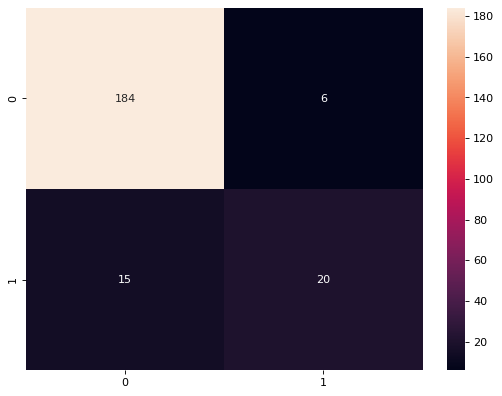

In [57]:
matrix = confusion_matrix(real, pred)
matrix.diagonal()/matrix.sum(axis=0)

plt.figure(figsize=(8, 6), dpi=80)
sns.heatmap(matrix, annot=True, fmt='d')

# Inference

In [160]:
preds = []
file_names_all = []

with torch.no_grad():
    net.eval()
    metrics = []
    for batch in tqdm(test_loader):
        images, file_names = batch
        images = images.to(Config.DEVICE)
        file_names_all.extend(file_names)
        
        y_pred = net(images)
        y_pred = torch.sigmoid(y_pred)
        y_pred = y_pred.view(-1)
        y_pred = torch.where(y_pred > 0.5, 1, 0)
        y_pred = y_pred.detach().cpu().numpy().tolist()
        preds.extend(y_pred)

  0%|          | 0/15 [00:00<?, ?it/s]

## Submit

In [162]:
submit = pd.DataFrame({'ID_img': [filen.split('.')[0] for filen in file_names_all], 'class': preds})
submit.to_csv('swin_base_2class.csv', index=False)
submit.head(5)

,ID_img,class
0,10942248620_77738287904_92317579456_8,1
1,11476252728_90946703888_83373466997_4,0
2,11758169966_65799840524_72283028069_1,0
3,12054928568_20130374464_8647095983_8,0
4,12219465515_74065178154_47483019939_5,0


In [ ]:
# submit = pd.DataFrame({'ID_img': pd.read_csv(Config.test_val_csv_path)['image'].str.split('.').str[0].reset_index(), 'class': preds})
# submit.to_csv('swin_baseline.csv', index=False)
# submit.head(5)

In [ ]:
# import IPython
# display(IPython.display.Audio(url="https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg", autoplay=True))

## watch predictions and merge csv

In [ ]:
# Past code here
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
swin_baseline = pd.read_csv('swin_baseline.csv')
swin_base_2class = pd.read_csv('swin_base_2class.csv')

In [ ]:
swin_baseline.head(10)

In [ ]:
swin_base_2class.head(10)

In [ ]:
swin_baseline = swin_baseline.set_index('ID_img').join(swin_base_2class.set_index('ID_img')['class'], rsuffix='2cl')
swin_baseline['class2cl'] = swin_baseline['class2cl'].replace({1:2})
swin_baseline.head(20)

In [ ]:
swin_baseline[swin_baseline['class2cl'] == 2].head(40)

Посмотрим на снимки класса 2, двух моделей

In [ ]:
for i, row in swin_baseline[swin_baseline['class']== 2].iterrows():
    image = Image.open(f'./test_dataset_test/{row.name}.jpg')
#     image.show()
    print(row.name)
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    plt.show()

In [ ]:
for i, row in swin_baseline[swin_baseline['class2cl']== 2].iterrows():
    image = Image.open(f'./test_dataset_test/{row.name}.jpg')
#     image.show()
    print(row.name)
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    plt.show()

In [ ]:
for i, row in swin_baseline[(swin_baseline['class']== 2) & (swin_baseline['class2cl'] != 2)].iterrows():
    image = Image.open(f'./test_dataset_test/{row.name}.jpg')
#     image.show()
    print(row.name)
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    plt.show()

Мержим csv

In [ ]:
swin_baseline['class2cl'] = swin_baseline['class2cl'].replace({0:1})

In [ ]:
idx_replace = swin_baseline[swin_baseline['class2cl']== 1].index
swin_baseline.loc[idx_replace,'class'] = swin_baseline.loc[idx_replace]['class2cl']

In [ ]:
# idx_replace = swin_baseline[swin_baseline['class2cl']== 2].index
# swin_baseline.loc[idx_replace,'class'] = swin_baseline.loc[idx_replace]['class2cl']

In [ ]:
swin_baseline.head(40)

In [ ]:
swin_baseline = swin_baseline.drop(columns=['class2cl'])
swin_baseline.to_csv('swin_merged_2cl_1.csv')

Opencv - detect blur

In [84]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [39]:
train_im_csv = pd.read_csv('../input/trash-containers/train_dataset_train/train.csv')
blur_imgs = train_im_csv[train_im_csv['class']==2] # possibly blurry
zero_class_imgs = train_im_csv[train_im_csv['class']==0]
first_class_imgs = train_im_csv[train_im_csv['class']==1]
train_image_path = '../input/trash-containers/train_dataset_train/train'
test_image_path = '../input/trash-containers/test_dataset_test'
blur_imgs.head(10)

,ID_img,class
102,220307011050_5e20cf51feb01506981f8c37bd3da5b6.jpg,2.0
103,220307011051_1c9b57d611d2a8a73e8d329cc4f9f18e.jpg,2.0
104,220307012717_4d221db014939a79f76539816d578863.jpg,2.0
105,220307012835_983e193301d76a2d1498a5f36beba908.jpg,2.0
106,220307013123_9d281d2e2e2c64a2077a372d69a37da0.jpg,2.0
107,220307013457_e82ef3f21f4f5ae8c3e58f7b1f68c379.jpg,2.0
108,220307013523_de874e46a1e3c812921ae4d4bc04a511.jpg,2.0
109,220307013601_6643532d77f0f624e1a2db7d462a34a2.jpg,2.0
110,220307013946_400cdaf7917e3a109bd4bff12a0322e4.jpg,2.0
111,220307014229_451c5e96d4ab7bc1387035fd1ae53a9a.jpg,2.0


In [59]:
def get_img_var(df, images_path, print_vars=True,):
    img_count = 0.0
    mean_var = 0.0
    vars_list = []
    for i, row in df.iterrows():
        img_count += 1
        image = cv2.imread(f'{images_path}/{row.iloc[0]}')
        var = cv2.Laplacian(image, cv2.CV_64F).var()
        mean_var += var
        vars_list.append(var)
    #     print(var)
    mean_var = mean_var / img_count
    median = np.median(np.array(vars_list))
    std = np.std(np.array(vars_list))
    max_var = np.max(np.array(vars_list))
    
    if print_vars:
        print(mean_var)
        print(median)
        print(std)
        print(max_var)
    
    return mean_var, median, std, max_var 

get_img_var(blur_imgs, train_image_path)

111.61990417155518
37.096175390936956
294.2158613859769
2188.4213077334916


(111.61990417155518, 37.096175390936956, 294.2158613859769, 2188.4213077334916)

In [97]:
blur_imgs_val = val_csv[val_csv['class'] == 1].reset_index()

In [61]:
get_img_var(blur_imgs_val, test_image_path)

1158.44338977541
981.9871912067913
1211.010443129155
7130.602528320263


(1158.44338977541, 981.9871912067913, 1211.010443129155, 7130.602528320263)

In [86]:
def detect_blur_fft(image, size=60):
    # grab the dimensions of the image and use the dimensions to
    # derive the center (x, y)-coordinates
    (h, w) = image.shape
    (cX, cY) = (int(w / 2.0), int(h / 2.0))
    # compute the FFT to find the frequency transform, then shift
    # the zero frequency component (i.e., DC component located at
    # the top-left corner) to the center where it will be more
    # easy to analyze
    fft = np.fft.fft2(image)
    fftShift = np.fft.fftshift(fft)
    fftShift[cY - size:cY + size, cX - size:cX + size] = 0
    fftShift = np.fft.ifftshift(fftShift)
    recon = np.fft.ifft2(fftShift)
    magnitude = 20 * np.log(np.abs(recon))
    mean = np.mean(magnitude)
    # the image will be considered "blurry" if the mean value of the
    # magnitudes is less than the threshold value
    plt.imshow(image, cmap='gray')
    return mean

9.090706684794755

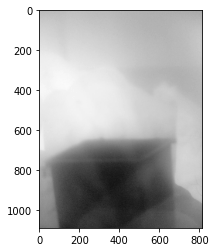

In [124]:
detect_blur_fft(cv2.imread(f'{test_image_path}/{blur_imgs_val.iloc[32,0]}', 0))